# Import Module

In [1]:
import torch
import glob
import warnings 
warnings.filterwarnings('ignore')

import random
import PIL
import cv2
import os
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import time

from torch.utils.data import Dataset, DataLoader

/home/user1/바탕화면/yes/envs/test/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Check GPU

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device : {device}")

Device : cuda


# Set seed and config

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=True

In [4]:
CFG={'SEED' : 42,
     'IMAGE_SIZE' : 224,
     'EPOCHS' : 60,
     'BATCH_SIZE' : 64,
     'LR' : 0.00001,
     'left_save_path' : f"/home/user1/바탕화면/HJ/AICOSS 2023 (Pnuemonia)/Codes/Left_Model.pt",
     'right_save_path' : f"/home/user1/바탕화면/HJ/AICOSS 2023 (Pnuemonia)/Codes/Right_Model.pt",
     'ensemble_save_path' : f"/home/user1/바탕화면/HJ/AICOSS 2023 (Pnuemonia)/Codes/LR_Ensemble.pt"}

In [5]:
seed_everything(CFG['SEED'])

# Get Data Path

In [6]:
def get_path(path):
    normal=[]
    vir=[]
    bact=[]

    normal_label = []
    vir_label = []
    bact_label = []

    for t in os.listdir(path):
        if t=='NORMAL':
            normal_path = f"{path}{t}/"
            for normal_data in glob.glob(normal_path + "/*.jpeg"):
                normal.append(normal_data)
                normal_label.append(np.array([1,0,0]))

        elif t=='VIRUS':
            vir_path = f"{path}{t}/"
            for vir_data in glob.glob(vir_path + "/*.jpeg"):
                vir.append(vir_data)
                vir_label.append(np.array([0,1,0]))
                
        elif t=='BACTERIA':
            bact_path = f"{path}{t}/"
            for bact_data in glob.glob(bact_path + "/*.jpeg"):
                bact.append(bact_data)
                bact_label.append(np.array([0,0,1]))

    return normal, vir, bact, normal_label, vir_label, bact_label

#Train
train_path = f"/home/user1/바탕화면/HJ/chest_xray/train/"
train_normal, train_vir, train_bact, train_normal_label, train_vir_label, train_bact_label = get_path(train_path)

# Test
test_path = f"/home/user1/바탕화면/HJ/chest_xray/test/"
test_normal, test_vir, test_bact, test_normal_label, test_vir_label, test_bact_label = get_path(test_path)

In [7]:
print(f"Train Normal : {len(train_normal)}\nTrain Virus : {len(train_vir)}\nTrain Bacteria : {len(train_bact)}\n")
print(f"Test normal : {len(test_normal)}\nTest Virus : {len(test_vir)}\nTest Bacteria : {len(test_bact)}\n")

Train Normal : 1341
Train Virus : 1345
Train Bacteria : 2530

Test normal : 234
Test Virus : 148
Test Bacteria : 242



In [8]:
train_data = train_normal + train_vir + train_bact
train_label = train_normal_label + train_vir_label + train_bact_label

# Normal / Virus 데이터가 Bacteria의 절반밖에 안된다 -> augmentation으로 data imbalance를 잡는다다다
train_aug = train_normal + train_vir
train_aug_label = train_normal_label + train_vir_label

test_data = test_normal + test_vir + test_bact
test_label = test_normal_label + test_vir_label + test_bact_label

/home/user1/바탕화면/HJ/chest_xray/train/NORMAL/NORMAL2-IM-0501-0001.jpeg
Image size => (1503, 1782, 3)


(-0.5, 1781.5, 1502.5, -0.5)

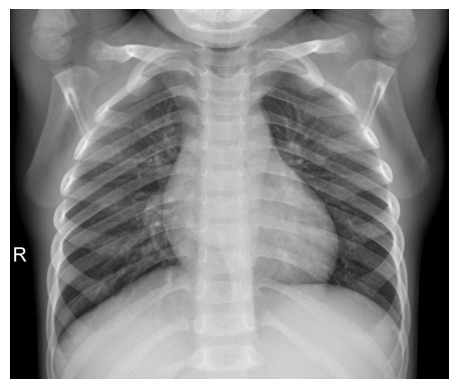

In [9]:
n = random.randint(0, len(train_data)-1)
print(f"{train_data[n]}")
img = cv2.imread(train_data[n])
print(f"Image size => {img.shape}")
plt.imshow(img)
plt.axis('off')

In [10]:
# 이미지 크기: (448,448)로 변환 [훈련/테스트 모두]
train_transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE'])),
    torchvision.transforms.ToTensor()
])

test_transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE'])),
    torchvision.transforms.ToTensor()
])

# Make Dataset

In [12]:
# Crop Dataset 만들기
# Crop: 이미지에서 불순물 제거 (완전히 제거하지는 못함, 테두리에 낀 불순물만)
# LR_split: 왼쪽 폐와 오른쪽 폐를 분리
class Cropdataset(Dataset):
    def __init__(self, path, label, transform=None):
        self.path = path
        self.label = label
        self.transform = transform
    
    def __len__(self):
        return len(self.path)
    
    def __get_img(self, path):
        img = cv2.imread(path)  # ndarray 형태로 반환

        return img
    
    def __crop__(self, img):
        dimension = len(img.shape)
    
        if dimension == 2:
            h,w = img.shape
        else:
            h,w,_ = img.shape
    
        crop_h = int(0.9 * h)
        crop_w = int(0.9 * w)
    
        if dimension == 2:
            cropped_image = img[h-crop_h : crop_h, w-crop_w : crop_w]
        else:
            cropped_image = img[h-crop_h : crop_h, w-crop_w : crop_w, :]
    
        return cropped_image  # PIL Image 반환
    
    def half(self, img):
        dimension = len(img.shape)
    
        if dimension == 2:
            _,w = img.shape
        else:
            _,w,_ = img.shape

        crop_w = int(0.5 * w)
    
        if dimension == 2:
            left = PIL.Image.fromarray(img[:, 0 : crop_w])
            right = PIL.Image.fromarray(img[:, crop_w : w])
        else:
            left = PIL.Image.fromarray(img[:, 0 : crop_w, :])
            right = PIL.Image.fromarray(img[:, crop_w : w, :])
    
        return left, right

    def __getitem__(self, index):
        path = self.path[index]
        label = self.label[index]

        img = self.__get_img(path)
        img = self.__crop__(img)
        left_img, right_img = self.half(img)

        if self.transform is not None:
            left_img = self.transform(left_img)
            right_img = self.transform(right_img)

        return left_img, right_img, torch.from_numpy(label)

In [13]:
# Augmented Dataset 만들기 (Crop한 이미지를 Horizontal Flip) -> 원래 데이터와 같은 양의 이미지 생성 (결론적으로 2배)
class Augmentedataset(Dataset):
    def __init__(self, path, label, transform=None):
        self.path = path
        self.label = label
        self.transform = transform
    
    def __len__(self):
        return len(self.path)
    
    def __get_img(self, path):
        img = cv2.imread(path)  # ndarray 형태로 반환

        return img
    
    def __crop__(self, img):
        dimension = len(img.shape)
    
        if dimension == 2:
            h,w = img.shape
        else:
            h,w,_ = img.shape
    
        crop_h = int(0.9 * h)
        crop_w = int(0.9 * w)
    
        if dimension == 2:
            cropped_image = PIL.Image.fromarray(img[h-crop_h : crop_h, w-crop_w : crop_w])
        else:
            cropped_image = PIL.Image.fromarray(img[h-crop_h : crop_h, w-crop_w : crop_w, :])
    
        return cropped_image  # PIL Image 반환
    
    def half(self, img):
        dimension = len(img.shape)

        if dimension == 2:
            _,w = img.shape
        else:
            _,w,_ = img.shape

        crop_w = int(0.5 * w)
    
        if dimension == 2:
            left = PIL.Image.fromarray(img[:, 0 : crop_w])
            right = PIL.Image.fromarray(img[:, crop_w : w])
        else:
            left = PIL.Image.fromarray(img[:, 0 : crop_w, :])
            right = PIL.Image.fromarray(img[:, crop_w : w, :])
    
        return left, right

    def __getitem__(self, index):
        path = self.path[index]
        label = self.label[index]

        img = self.__get_img(path)
        img = self.__crop__(img)  # Returns PIL Image
        img = torchvision.transforms.functional.hflip(img)
        img = np.array(img)  # ndarray로 변환
        left_img, right_img = self.half(img)

        if self.transform is not None:
            left_img = self.transform(left_img)
            right_img = self.transform(right_img)

        return left_img, right_img, torch.from_numpy(label)

In [14]:
train_crop_dataset = Cropdataset(train_data, train_label, train_transform)  # t_c_dataset: [LEFT, RIGHT, LABEL]
train_aug_dataset = Augmentedataset(train_aug, train_aug_label, train_transform)  # t_a_dataset: [LEFT, RIGHT, LABEL]
train_dataset = train_crop_dataset + train_aug_dataset
train_dataloader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)

In [15]:
left, right, label = next(iter(train_dataloader))

(<Axes: >, <matplotlib.image.AxesImage at 0x7fa1d95c3ac0>)

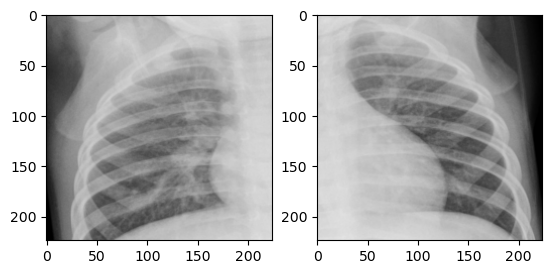

In [33]:
# len(train_dataloader.dataset)  # 7902개의 이미지
from torchvision.transforms.functional import to_pil_image
left_img = to_pil_image(left[38])
right_img = to_pil_image(right[38])
plt.subplot(1,2,1), plt.imshow(left_img)
plt.subplot(1,2,2), plt.imshow(right_img)

In [17]:
print(f"Left Image Shape : {left[0].shape}")
print(f"Right Image Shape : {right[0].shape}")
print(f"Left Image Shape : {label[0].shape}")

Left Image Shape : torch.Size([3, 224, 224])
Right Image Shape : torch.Size([3, 224, 224])
Left Image Shape : torch.Size([3])


# Define Model

In [15]:
import timm

class Model(nn.Module):
    def __init__(self, classes=3):
        super().__init__()
        self.model = timm.create_model('resnet50', pretrained=True)
        self.fc2 = nn.Linear(in_features=1000, out_features=classes, bias=True)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, y):
        x = self.model(x)
        x = self.fc2(x)
        x = self.softmax(x)

        return x

In [46]:
left_model = Model().to(device)
right_model = Model().to(device)
# left_model = nn.DataParallel(left_model).to(device)
left_model

Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum

# Define Loss, Optimizer

In [17]:
loss_fn_left = nn.CrossEntropyLoss().to(device)
optimizer_left = torch.optim.Adam(left_model.parameters(), lr=CFG['LR'])

# Training (Left Images)

In [21]:
def train_LEFT(dataloader, model, optimizer, loss_fn, model_save_path):
    model.train()

    size = len(dataloader)  # 124 batches in 1 epoch
    datasize = len(dataloader.dataset)  # 7902 images in total

    loss_hist=[]
    acc_hist=[]

    for epoch in range(CFG['EPOCHS']):
        epoch_start = time.time()

        loss_item=0
        correct=0
        print(f"Start epoch : {epoch+1}")
        for batch, (L, _, y) in enumerate(dataloader):
            L = L.to(device).float()
            y = y.to(device).float()

            output = model(L)

            loss = loss_fn(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_item += loss.item()

            correct+=(output.argmax(1)==y.argmax(1)).detach().cpu().sum().item()

            if batch % 30 == 0:
                print(f"Batch loss : {(loss):>.5f} {batch}/{size}")

        loss_hist.append(loss_item/size)
        acc_hist.append(correct/datasize*100)

        print(f"Loss : {(loss_item/size):>.5f} ACC : {(correct/datasize*100):>.2f}%")

        epoch_end = time.time()
        print(f"End epoch : {epoch+1}")
        print(f"Epoch time : {(epoch_end-epoch_start)//60} min {(epoch_end-epoch_start)%60} sec")
        print()

    torch.save(model.state_dict(), model_save_path)

    return loss_hist, acc_hist

In [22]:
left_loss, left_acc = train_LEFT(train_dataloader, left_model, optimizer_left, loss_fn_left, CFG['left_save_path'])

Start epoch : 1
Batch loss : 0.00958 0/124
Batch loss : 0.00882 30/124
Batch loss : 0.00873 60/124
Batch loss : 0.00807 90/124
Batch loss : 0.00808 120/124
Loss : 1.06362 ACC : 44.91%
End epoch : 1
Epoch time : 5.0 min 21.953702211380005 sec

Start epoch : 2
Batch loss : 0.00839 0/124
Batch loss : 0.00817 30/124
Batch loss : 0.00773 60/124
Batch loss : 0.00757 90/124
Batch loss : 0.00761 120/124
Loss : 0.96309 ACC : 62.57%
End epoch : 2
Epoch time : 5.0 min 17.090091705322266 sec

Start epoch : 3
Batch loss : 0.00768 0/124
Batch loss : 0.00737 30/124
Batch loss : 0.00714 60/124
Batch loss : 0.00699 90/124
Batch loss : 0.00670 120/124
Loss : 0.89261 ACC : 70.72%
End epoch : 3
Epoch time : 5.0 min 17.001648664474487 sec

Start epoch : 4
Batch loss : 0.00654 0/124
Batch loss : 0.00726 30/124
Batch loss : 0.00693 60/124
Batch loss : 0.00663 90/124
Batch loss : 0.00684 120/124
Loss : 0.84923 ACC : 73.35%
End epoch : 4
Epoch time : 5.0 min 16.706900596618652 sec

Start epoch : 5
Batch loss :

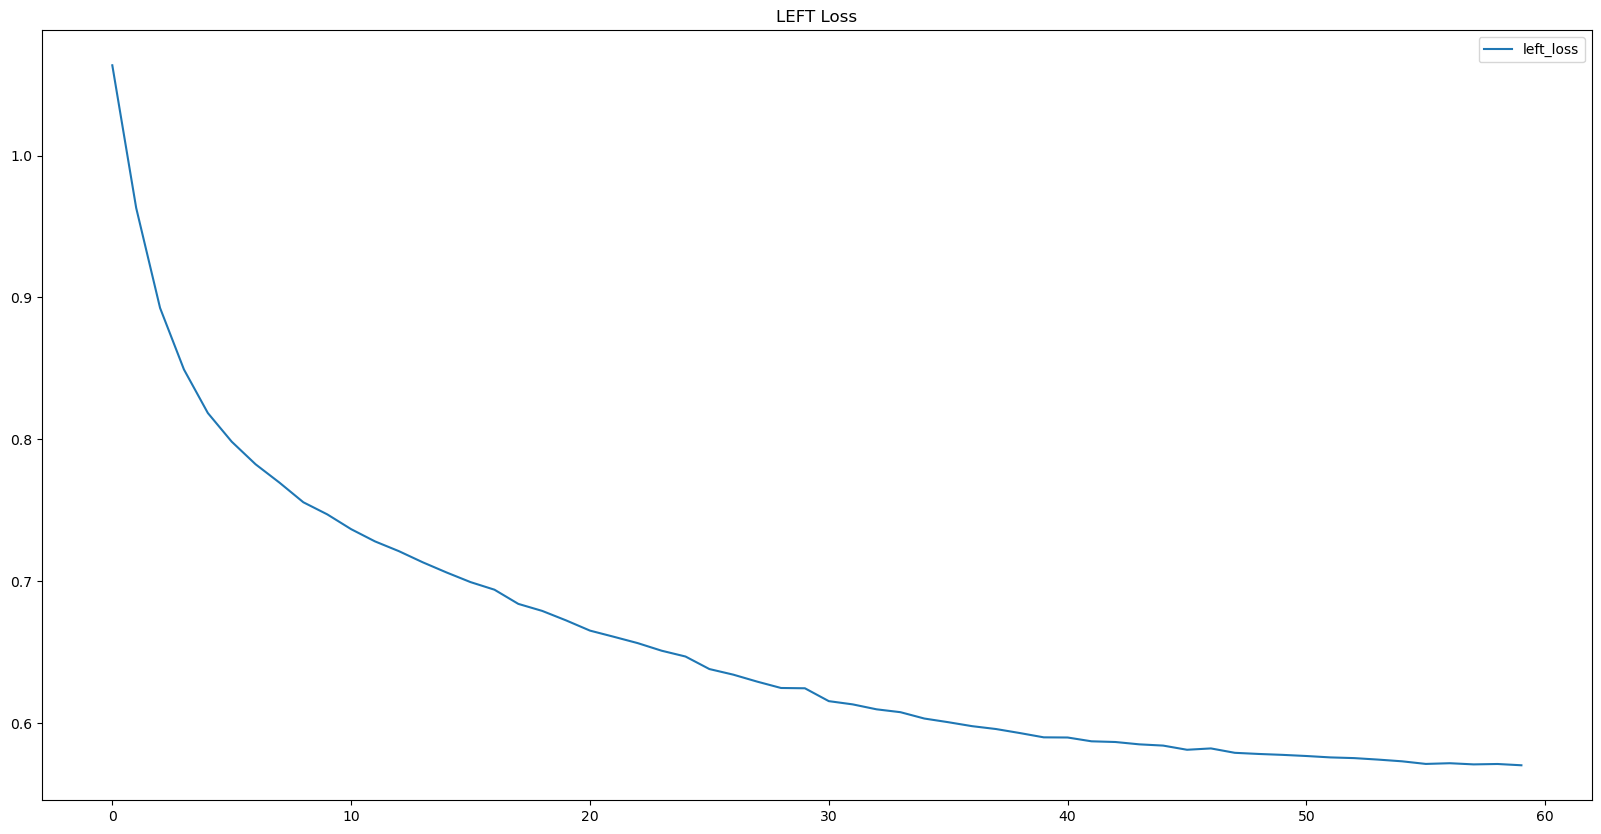

In [23]:
plt.figure(figsize=(20,10))
plt.plot(left_loss, label='left_loss')  # label을 출력하고 싶으면 plt.legend() 사용하면 됨
plt.title('LEFT Loss')
plt.legend()

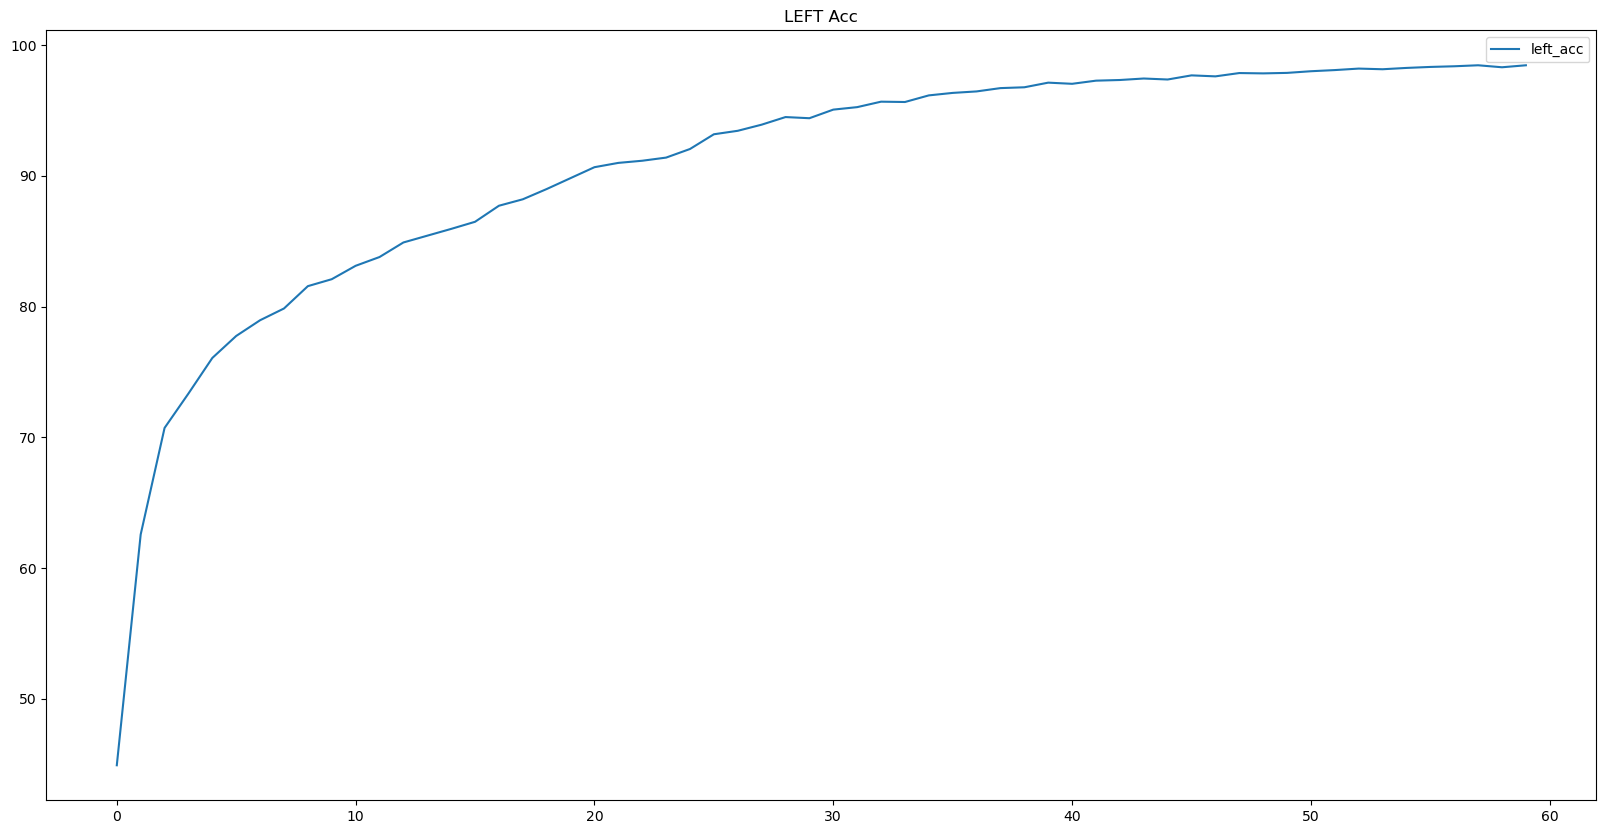

In [24]:
plt.figure(figsize=(20,10))
plt.plot(left_acc, label='left_acc')
plt.title('LEFT Acc')
plt.legend()

# TRAIN RIGHT

In [25]:
def train_RIGHT(dataloader, model, optimizer, loss_fn, model_save_path):
    model.train()

    size = len(dataloader)  # 124 batches in 1 epoch
    datasize = len(dataloader.dataset)  # 7902 images in total

    loss_hist=[]
    acc_hist=[]

    for epoch in range(CFG['EPOCHS']):
        epoch_start = time.time()

        loss_item=0
        correct=0
        print(f"Start epoch : {epoch+1}")
        for batch, (_, R, y) in enumerate(dataloader):
            R = R.to(device).float()
            y = y.to(device).float()

            output = model(R)

            loss = loss_fn(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_item += loss.item()

            correct+=(output.argmax(1)==y.argmax(1)).detach().cpu().sum().item()

            if batch % 30 == 0:
                print(f"Batch loss : {(loss):>.5f} {batch}/{size}")

        loss_hist.append(loss_item/size)
        acc_hist.append(correct/datasize*100)

        print(f"Loss : {(loss_item/size):>.5f} ACC : {(correct/datasize*100):>.2f}%")

        epoch_end = time.time()
        print(f"End epoch : {epoch+1}")
        print(f"Epoch time : {(epoch_end-epoch_start)//60} min {(epoch_end-epoch_start)%60} sec")
        print()

    torch.save(model.state_dict(), model_save_path)

    return loss_hist, acc_hist

In [35]:
loss_fn_right = nn.CrossEntropyLoss().to(device)
optimizer_right = torch.optim.Adam(right_model.parameters(), lr=CFG['LR'])
right_loss, right_acc = train_RIGHT(train_dataloader, right_model, optimizer_right, loss_fn_right, CFG['right_save_path'])

Start epoch : 1
Batch loss : 1.11841 0/124
Batch loss : 1.06581 30/124
Batch loss : 1.04370 60/124
Batch loss : 1.07582 90/124
Batch loss : 1.02229 120/124
Loss : 1.06690 ACC : 44.33%
End epoch : 1
Epoch time : 5.0 min 15.95694637298584 sec

Start epoch : 2
Batch loss : 0.98833 0/124
Batch loss : 0.95712 30/124
Batch loss : 1.01227 60/124
Batch loss : 0.92175 90/124
Batch loss : 0.90906 120/124
Loss : 0.94640 ACC : 62.34%
End epoch : 2
Epoch time : 5.0 min 17.280149936676025 sec

Start epoch : 3
Batch loss : 0.87253 0/124
Batch loss : 0.87733 30/124
Batch loss : 0.91244 60/124
Batch loss : 0.91954 90/124
Batch loss : 0.90593 120/124
Loss : 0.87462 ACC : 70.63%
End epoch : 3
Epoch time : 5.0 min 17.62515640258789 sec

Start epoch : 4
Batch loss : 0.86051 0/124
Batch loss : 0.80373 30/124
Batch loss : 0.84465 60/124
Batch loss : 0.84218 90/124
Batch loss : 0.74569 120/124
Loss : 0.83662 ACC : 73.07%
End epoch : 4
Epoch time : 5.0 min 14.725367069244385 sec

Start epoch : 5
Batch loss : 0

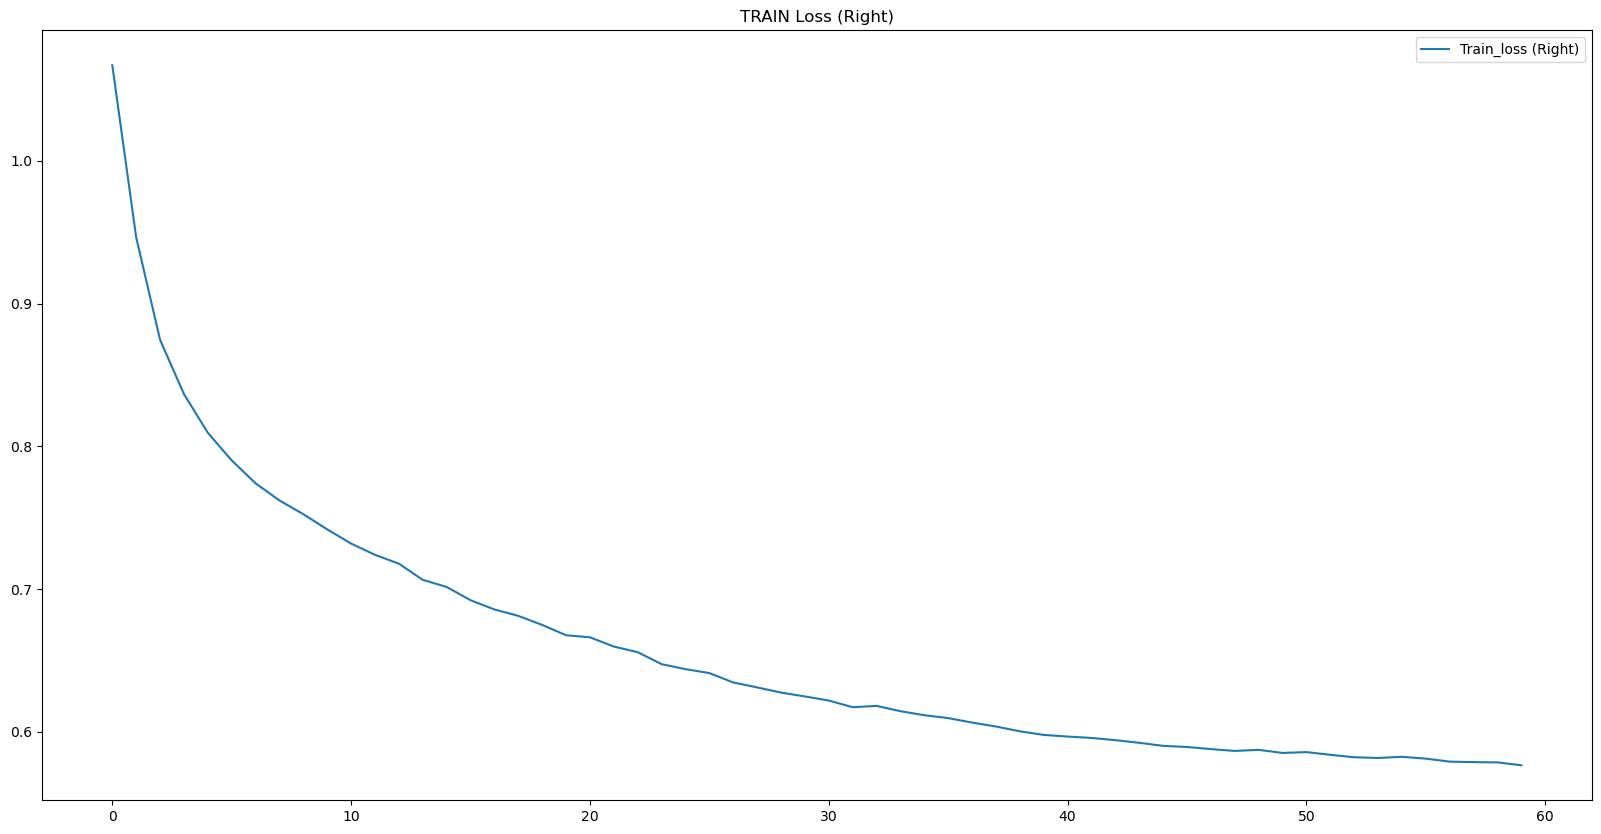

In [36]:
plt.figure(figsize=(20,10))
plt.plot(right_loss, label='Train_loss (Right)')
plt.title('TRAIN Loss (Right)')
plt.legend()

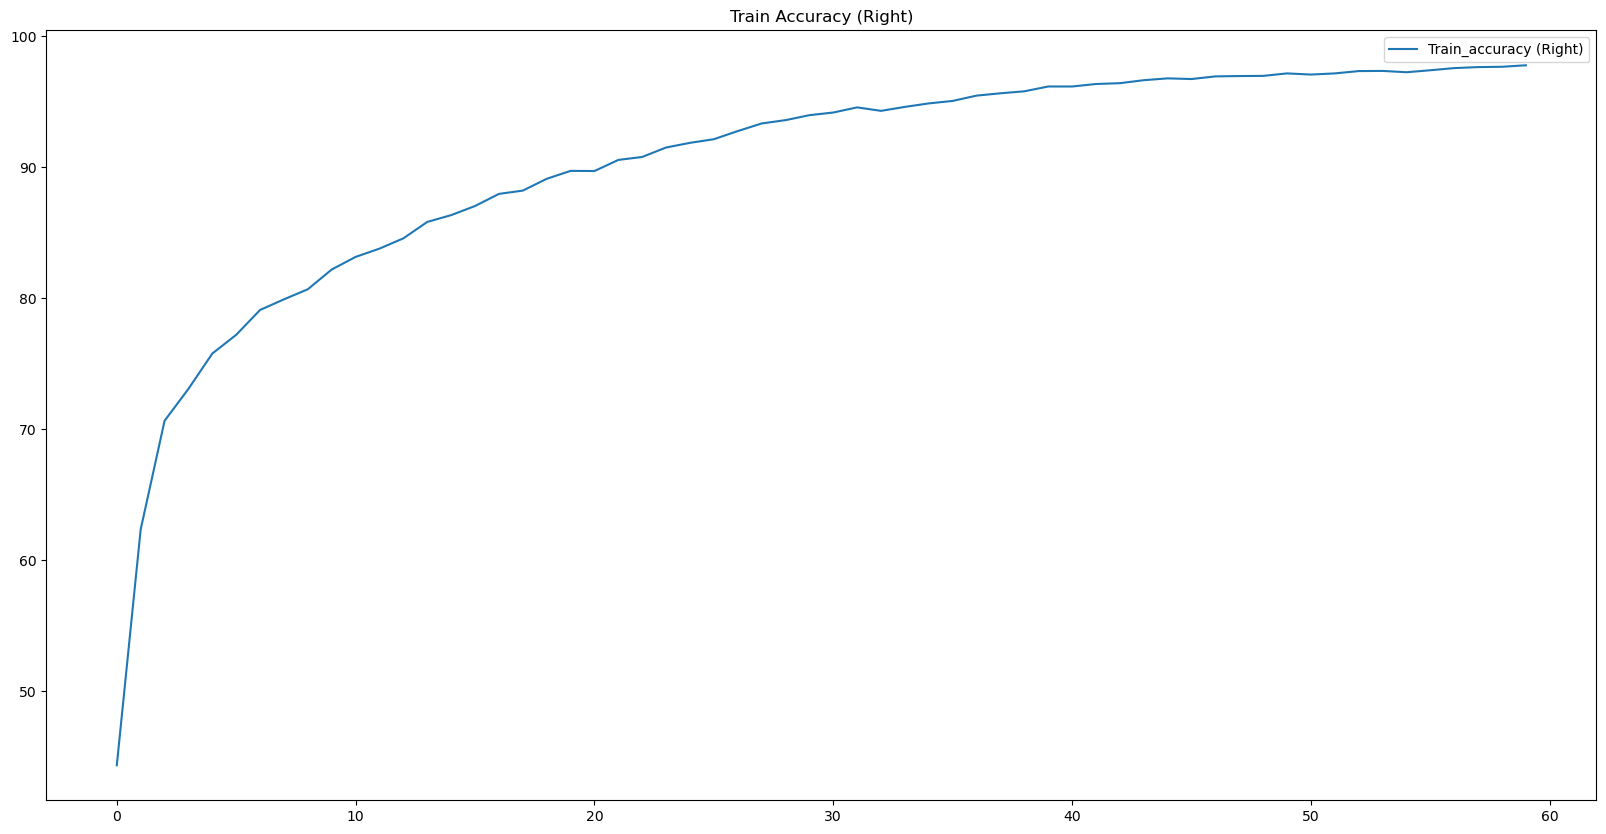

In [37]:
plt.figure(figsize=(20,10))
plt.plot(right_acc, label='Train_accuracy (Right)')
plt.title('Train Accuracy (Right)')
plt.legend()

# TEST Left

In [18]:
test_crop_dataset = Cropdataset(test_data, test_label, test_transform)  # [LEFT, RIGHT, LABEL]
test_aug_dataset = Augmentedataset(test_vir, test_vir_label, test_transform)  # [LEFT, RIGHT, LABEL]
test_dataset = test_crop_dataset + test_aug_dataset
test_dataloader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)

In [19]:
def test_LEFT(dataloader, model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()

    pred_normal=[]
    pred_virus=[]
    pred_bacteria=[]
    label_normal=[]
    label_virus=[]
    label_bacteria=[]
    
    label=[]
    pred=[]

    for (L, _, y) in dataloader:
        for t in y:
            label.append(t.detach().tolist())
            label_normal.append(t[0].detach().tolist())
            label_virus.append(t[1].detach().tolist())
            label_bacteria.append(t[2].detach().tolist())

        L = L.to(device).float()
        y = y.to(device).float()

        output = model(L)

        for o in output:
            pred.append(o.detach().cpu().tolist())
            pred_normal.append(o[0].detach().cpu().tolist())
            pred_virus.append(o[1].detach().cpu().tolist())
            pred_bacteria.append(o[2].detach().cpu().tolist())

    return label_normal, label_virus, label_bacteria, pred_normal, pred_virus, pred_bacteria, np.array(label), np.array(pred)

In [20]:
left_label_normal, left_label_virus, left_label_bacteria, left_pred_normal, left_pred_virus, left_pred_bacteria, left_label, left_pred  = test_LEFT(test_dataloader, left_model, CFG['left_save_path'])

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns

In [22]:
left_OH_pred = []

for vector in left_pred:
    left_OH_pred.append(np.argmax(vector, axis=0))

left_OH_label = []

for vector in left_label:
    left_OH_label.append(np.argmax(vector, axis=0))

<Axes: >

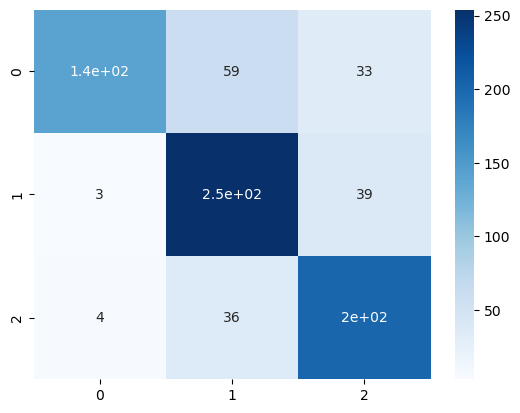

In [23]:
cm = confusion_matrix(left_OH_label, left_OH_pred)
sns.heatmap(cm, annot=True, cmap='Blues')

In [59]:
def correct_count(pred, label):
    total = len(pred)  # Test 데이터 개수
    n_correct = 0
    v_correct = 0
    b_correct = 0

    for idx in range(total):
        pred_now = pred[idx]
        label_now = label[idx]

        pred_idx = np.argmax(pred_now, axis=0)
        label_idx = np.argmax(label_now, axis=0)

        if (pred_idx == label_idx):
            if pred_idx == 0:
                n_correct += 1
            elif pred_idx == 1:
                v_correct += 1
            else:
                b_correct += 1
    
    return n_correct, v_correct, b_correct

In [63]:
def nvb_size(label):
    total = len(label)
    total_n = 0
    total_v = 0
    total_b = 0

    for idx in range(total):
        now = label[idx]
        if now[0] == 1:
            total_n += 1
        elif now[1] == 1:
            total_v += 1
        else:
            total_b += 1
        
    return total_n, total_v, total_b

In [65]:
L_total_n, L_total_v, L_total_b = nvb_size(left_label)

L_n_correct, L_v_correct, L_b_correct = correct_count(left_pred, left_label)
print(f"Normal sensitivity: {L_n_correct/L_total_n}")
print(f"Virus sensitivity: {L_v_correct/L_total_v}")
print(f"Bacteria sensitivity: {L_b_correct/L_total_b}")

Normal sensitivity: 0.6068376068376068
Virus sensitivity: 0.8581081081081081
Bacteria sensitivity: 0.8347107438016529


# TEST Right

In [24]:
def test_RIGHT(dataloader, model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()

    pred_normal=[]
    pred_virus=[]
    pred_bacteria=[]
    label_normal=[]
    label_virus=[]
    label_bacteria=[]
    
    label=[]
    pred=[]

    for (_, R, y) in dataloader:
        for t in y:
            label.append(t.detach().tolist())
            label_normal.append(t[0].detach().tolist())
            label_virus.append(t[1].detach().tolist())
            label_bacteria.append(t[2].detach().tolist())

        R = R.to(device).float()
        y = y.to(device).float()

        output = model(R)

        for o in output:
            pred.append(o.detach().cpu().tolist())
            pred_normal.append(o[0].detach().cpu().tolist())
            pred_virus.append(o[1].detach().cpu().tolist())
            pred_bacteria.append(o[2].detach().cpu().tolist())

    return label_normal, label_virus, label_bacteria, pred_normal, pred_virus, pred_bacteria, np.array(label), np.array(pred)

In [25]:
right_label_normal, right_label_virus, right_label_bacteria, right_pred_normal, right_pred_virus, right_pred_bacteria, right_label, right_pred  = test_RIGHT(test_dataloader, right_model, CFG['right_save_path'])

In [29]:
right_OH_pred = []

for vector in right_pred:
    right_OH_pred.append(np.argmax(vector, axis=0))

right_OH_label = []

for vector in right_label:
    right_OH_label.append(np.argmax(vector, axis=0))

<Axes: >

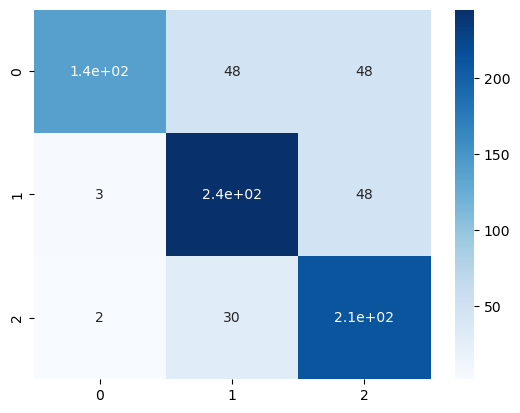

In [30]:
cm = confusion_matrix(right_OH_label, right_OH_pred)
sns.heatmap(cm, annot=True, cmap='Blues')

In [66]:
R_total_n, R_total_v, R_total_b = nvb_size(right_label)

R_n_correct, R_v_correct, R_b_correct = correct_count(right_pred, right_label)
print(f"Normal sensitivity: {R_n_correct/R_total_n}")
print(f"Virus sensitivity: {R_v_correct/R_total_v}")
print(f"Bacteria sensitivity: {R_b_correct/R_total_b}")

Normal sensitivity: 0.5897435897435898
Virus sensitivity: 0.8277027027027027
Bacteria sensitivity: 0.8677685950413223


# TEST Ensemble

In [38]:
def test_MERGE(left_pred, right_pred, label):
    merged_pred = (left_pred + right_pred)/2  # 772개 (Test dataset 전체)
    OH_pred = []
    OH_label = []

    for pred in merged_pred:
        OH_pred.append(np.argmax(pred, axis=0))
    for vector in label:
        OH_label.append(np.argmax(vector, axis=0))

    return OH_pred, OH_label

In [43]:
OH_pred, OH_label = test_MERGE(left_pred, right_pred, left_label)

<Axes: >

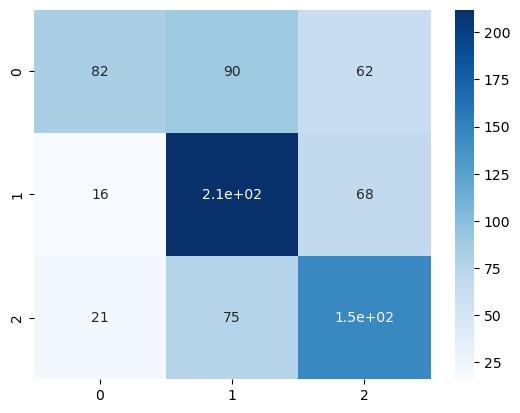

In [44]:
cm = confusion_matrix(OH_label, OH_pred)
sns.heatmap(cm, annot=True, cmap='Blues')